In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
import seaborn as sns

In [152]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

ibmqfactory.load_account:WARNING:2020-08-06 11:43:37,359: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams, conv #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [197]:
qb = 18 # qubit to operate on

# Conversion factors from standard SI units
us = 1e6
ns = 1e9
GHz = 1e-9

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 18 has a 
  - T1 time of 81.16087497411203 microseconds
  - T2 time of 61.776179867755005 microseconds
  - U2 gate error of 0.000396700024413705
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.33493402758096 GHz


In [198]:
shots = 1024 # determines clarity of results

period = 2000 # Rabi oscillation period
cycles = [5, 20, 40, 80, 160] # number of rabi cycles to perform for each oscillation
cycles_to_plot = 5 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const_arr = [54.07447683508908, 23.66156363955276, 60.71437458094607, 39.3158030358485, 99.20715774307718, 49.95313684255335, 58.41743781494493, 25.581627006241156, 59.29925139248408, 66.48049584501037,  55.96049466992817, 61.0468753438098,  69.53956380480695, 53.04738616311787, 35.92255650292224, 70.92519866266184, 76.16056132506117, 66.61375917115514, 80.8160184821598, 39.766803375498874]
predict_power_arr =  [-0.9924372112785861, -0.9940037912357684, -0.9478600149564859, -0.9990003473358622, -0.9545547178832068, -0.9741980721203277, -0.9507668252877607, -0.988440471817147, -0.9705356561002346, -0.9759707562681753, -0.9863270037625501, -0.9919133368276755, -0.9688283405688723, -0.9755092917894524, -0.9784188437551748, -0.9561175027847064, -0.9607519043146192, -0.9620204924453801, -0.9765823562601296, -0.9826959748384742]
predict_const = 25.086050253334367 #predict_const_arr[qb]
predict_power = -1.0111283460953973 #predict_power_arr[qb]

sig_predict_const_arr = [11.48089749887833, 5.35893609525708, 11.45245806804462, 8.422591490016428, 8.422591490016428, 10.668276009484188, 11.650031111752481, 5.687450116117995, 11.519876740103824, 13.072317572938855, 10.156982416076294, 11.929204320355337, 13.41656375569742, 11.09074144750751, 7.601093075606327, 15.113382279092622, 16.434457262102157, 13.78818074531042, 15.740548839704724, 8.565551825229692]
sig_predict_power_arr = [-0.9672752940591574, -0.9654741107610489, -0.9847146457687506, -0.9748121973084468, -0.9748121973084468, -0.9604334841997333, -0.9691865136543687, -0.9648929117844334, -0.9862872564599189, -0.9827775368102274, -1.026503852980569, -0.9990248777026389, -0.9910375292741338, -0.9659428057129544, -0.9666488482050365, -0.9420720154939807, -0.9389201013042705, -0.9609761215025634, -0.9949494583639722, -0.9671575177512337]
sig_predict_const = 5.414610364800357 #sig_predict_const_arr[qb]
sig_predict_power = -0.9878921794916214 #sig_predict_power_arr[qb]

In [199]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = period // 64 # density of datapoints in a cycle capture
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        64)
    
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = get_closest_multiple_of_16(drive_times[i] - (6 * drive_sigma))

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
                    
        # add end cap
        this_schedule += Play(end_cap, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

In [200]:
len(experiments)

777

In [201]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [114]:
job = backend.retrieve_job('5f2c1be07e879d001343c0bb')

In [140]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [141]:
qb_rabi_data = []
all_params = []
all_fits = []
all_convs = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p, c = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 5])
    all_params.append(p)
    all_convs.append(c)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    
    single_period_data = np.array(single_period_data)
    # residual sum of squares
    ss_res = np.sum((single_period_data - np.array(y_fit)) ** 2)
    # total sum of squares
    ss_tot = np.sum((single_period_data - np.mean(single_period_data)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    
    all_fits.append(y_fit)

0.9931431094947972
0.9931850858892205
0.9851059928269276
0.9503009798709282
0.9291005278708154


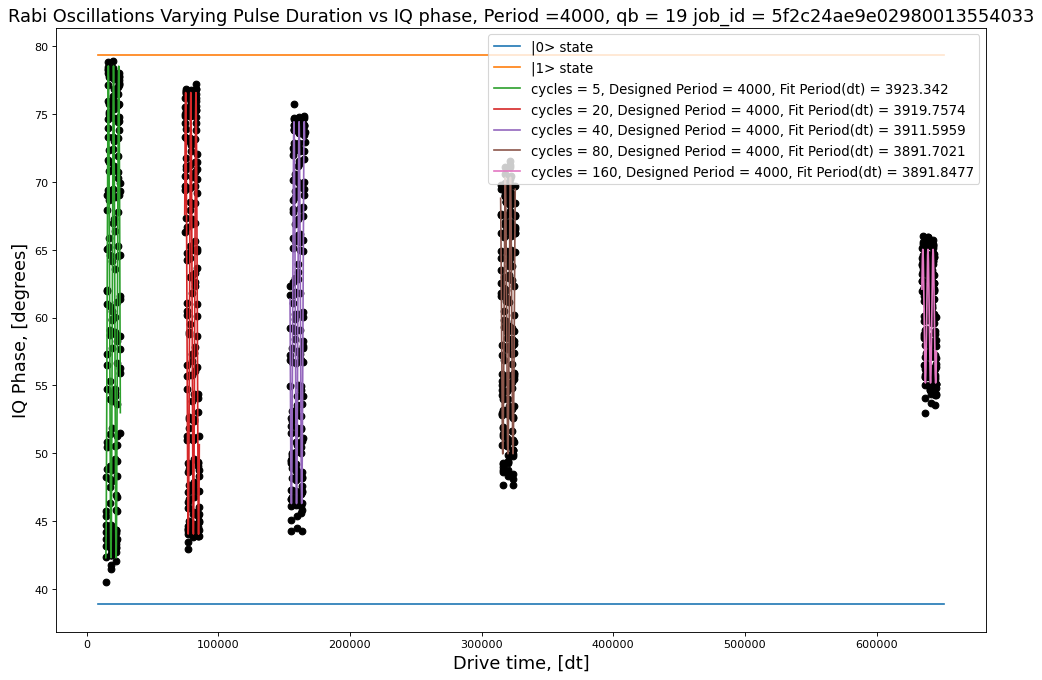

In [142]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

start_plot_time = (period*cycles[0])-(len(data_times[0]) * 64)
end_plot_time = (period*cycles[-1])+(len(data_times[-1]) * 64)
plt.plot([start_plot_time, end_plot_time],2*[state0],label="|0> state")
plt.plot([start_plot_time, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb) + " job_id = " + str(job.job_id()), fontsize=16)
# plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase", fontsize=16)
plt.show()

In [143]:
sigma = []
for i in all_convs:
    print(i)
    perr = np.sqrt(np.diag(i))
    print(perr)
    sigma.append(perr[0])
    print()

[[ 1.34200985e-02 -7.03813599e-04  2.12253917e-02 -2.08915869e-04]
 [-7.03813599e-04  6.88547494e-03 -8.42723892e-02  7.17345445e-04]
 [ 2.12253917e-02 -8.42723892e-02  2.30504344e+01 -1.89893748e-01]
 [-2.08915869e-04  7.17345445e-04 -1.89893748e-01  1.60353393e-03]]
[0.11584515 0.08297876 4.80108679 0.04004415]

[[ 1.07502497e-02 -4.36717049e-05 -3.23046295e-02  1.06211068e-03]
 [-4.36717049e-05  5.64241866e-03 -9.61294544e-03  2.75412756e-04]
 [-3.23046295e-02 -9.61294544e-03  2.81648907e+01 -9.20809651e-01]
 [ 1.06211068e-03  2.75412756e-04 -9.20809651e-01  3.01490845e-02]]
[0.10368341 0.07511603 5.30706046 0.17363492]

[[ 1.76894198e-02 -5.29655141e-04  1.24802751e-02 -8.77035438e-04]
 [-5.29655141e-04  9.21947323e-03  1.09394173e-01 -7.12035604e-03]
 [ 1.24802751e-02  1.09394173e-01  5.57209158e+01 -3.65590050e+00]
 [-8.77035438e-04 -7.12035604e-03 -3.65590050e+00  2.39959264e-01]]
[0.13300158 0.09601809 7.46464438 0.48985637]

[[ 3.22269278e-02 -1.97874851e-03 -1.88359226e-01  2

In [144]:
for i in range(len(cycles)):
    print(f'{abs(np.array(all_params)[:,0][i])}')
print()
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')
print()
print(sigma)

18.144607902111797
16.291188485710364
14.08742369041241
10.19928834254793
4.92821601445807

38.38203039996873
34.329278782863305
31.441484703588245
23.93761349193352
13.053678574384847

[0.11584514862784032, 0.10368341094599016, 0.1330015783690931, 0.17951860019036686, 0.10464704935791447]


0.9999382719516287


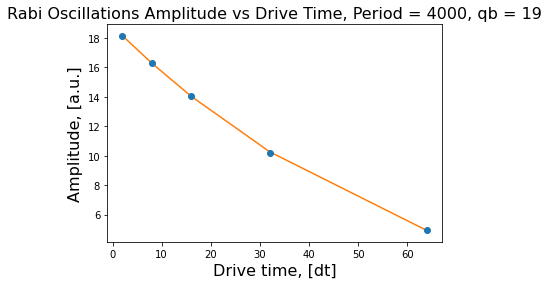

In [145]:
xvals = [(period*i)/10000 for i in cycles]
amps = abs(np.array(all_params)[:,0])
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, conv = curve_fit(func, xvals, amps, [4, 0.1, 1], sigma)
y_fit = [func(x, p[0], p[1], p[2]) for x in xvals]

amps = np.array(amps)
# residual sum of squares
ss_res = np.sum((amps - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((amps - np.mean(amps)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(xvals, amps, yerr=sigma, fmt='o')
plt.plot(xvals, y_fit)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Rabi Oscillations Amplitude vs Drive Time, Period = " + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [146]:
print(p)
print(f'{p[1]}')
print(f'{drive_amp}')
print(conv)

[ 2.28046609e+01  1.46839470e-02 -3.98701586e+00]
0.014683947037419239
0.006631535953086938
[[ 2.48103924e-01 -2.74446279e-04 -2.62475502e-01]
 [-2.74446279e-04  3.13298339e-07  2.93173509e-04]
 [-2.62475502e-01  2.93173509e-04  2.78897807e-01]]


[0.033381259, 0.022056032, 0.01643739, 0.013085348, 0.010860692, 0.009277566, 0.008093996]
[0.024875396152213604, 0.009966940152213609, 0.010523159152213609, 0.014900778152213608, 0.013266156152213606, 0.013051796152213609, 0.016061134152213608]
[0.015449119360015315, 0.009995586531064598, 0.006191583287011489, 0.003271420303171086, 0.0015145109078511122, 0.000359120247271022, 0.0005635924955142678]
0.47796282784779454


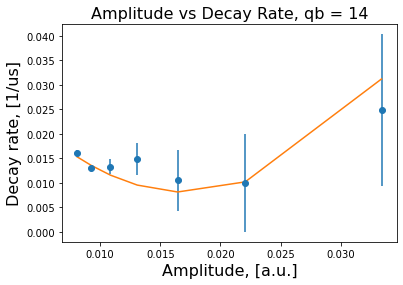

[ 8.78306128e+01 -3.01376769e+00  3.39302018e-02]


In [249]:
qb = 14

more_conv = [
[[ 1.95948595e+00, -2.14745038e-02, -2.00463953e+00],
 [-2.14745038e-02,  2.38675289e-04,  2.20302083e-02],
 [-2.00463953e+00,  2.20302083e-02,  2.05249186e+00]],
[[ 3.81670284e+00, -1.94300390e-02, -3.88345723e+00],
 [-1.94300390e-02,  9.99117501e-05,  1.98030281e-02],
 [-3.88345723e+00,  1.98030281e-02,  3.95311397e+00]],
[[ 8.13488614e-01, -5.52946631e-03, -8.38125783e-01],
 [-5.52946631e-03,  3.83357036e-05,  5.72063021e-03],
 [-8.38125783e-01,  5.72063021e-03,  8.64716463e-01]],
[[ 7.67417514e-02, -8.73230977e-04, -8.24126144e-02],
 [-8.73230977e-04,  1.07021908e-05,  9.63504190e-04],
 [-8.24126144e-02,  9.63504190e-04,  8.96343573e-02]],
[[ 1.18433675e-02, -1.56478485e-04, -1.30691739e-02],
 [-1.56478485e-04,  2.29374329e-06,  1.80938240e-04],
 [-1.30691739e-02,  1.80938240e-04,  1.47981018e-02]],
[[ 4.23111904e-04, -6.72938959e-06, -4.73873855e-04],
 [-6.72938959e-06,  1.28967352e-07,  8.32715320e-06],
 [-4.73873855e-04,  8.32715320e-06,  5.64392896e-04]],
[[ 2.72274036e-04, -6.54133352e-06, -2.84154830e-04],
 [-6.54133352e-06,  3.17636501e-07,  1.10407860e-05],
 [-2.84154830e-04,  1.10407860e-05,  4.17486024e-04]]
]

gammas_tilde = [0.036942404, 0.022033948, 0.022590167, 0.026967786, 0.025333164, 0.025118804, 0.028128142]
amplitudes = [0.033381259, 0.022056032, 0.01643739, 0.013085348, 0.010860692, 0.009277566, 0.008093996]




more_sigma = [np.sqrt(np.diag(i))[1] for i in more_conv]
gammas = [g - 1/(props.t1(qb) * us) for g in gammas_tilde]
print(amplitudes)
print(gammas)
print(more_sigma)


def func(x, a, b, c):
    return  a * x**2 + b*x + c

p, pcov = curve_fit(func, amplitudes, gammas, [5, 0, 0], more_sigma, maxfev=5000)
y_fit = [func(x, p[0], p[1], p[2]) for x in amplitudes]

gammas = np.array(gammas)
ss_res = np.sum((gammas - np.array(y_fit)) ** 2)
ss_tot = np.sum((gammas - np.mean(gammas)) ** 2)
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(amplitudes, gammas, yerr=more_sigma, fmt='o')
plt.plot(amplitudes, y_fit)
plt.ylabel('Decay rate, [1/us]', fontsize=16)
plt.xlabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Amplitude vs Decay Rate, qb = " + str(qb), fontsize=16)
plt.show()

print(p)

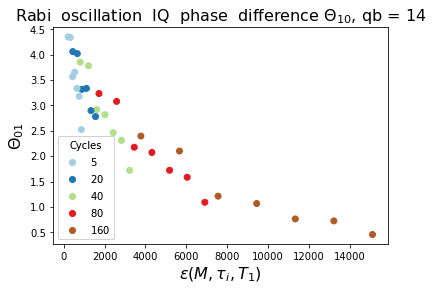

In [250]:
errors = []
cycles = np.array([5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160])
periods = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
inv_T1 = 1 / (props.t1(qb) * us)

# 0
# amps = [4.617710739, 4.351782188, 3.929665083, 3.209085447, 2.709938099, 4.867971959, 4.498334917, 4.026202528, 3.346237366, 2.576509753, 4.766859053, 4.32508765, 3.816748538, 3.03355349, 1.953926147, 4.443016216, 4.029763913, 3.526323838, 2.884357198, 1.84297663, 4.50958548, 3.999831676, 3.408507583, 2.607163711, 1.490607971, 4.463362893, 3.944515979, 3.300074297, 2.446771991, 1.289007061, 4.28538436, 3.692278193, 3.135415908, 2.188505079, 1.12132314] 
# drive_amps = [0.052885571, 0.035148278, 0.026303481, 0.021007033, 0.017481556, 0.014966599, 0.013082455]

# 1
# drive_amps = [0.023133165, 0.015384435, 0.01151832, 0.009202260, 0.007660121, 0.006559715, 0.005735129]
# amps = [5.217778043, 4.900298225, 4.326107335, 3.305675878, 2.554938727, 5.160890116, 4.791931535, 4.232594026, 3.422909473, 2.330834417, 4.830029438, 4.423696332, 3.904144607, 3.130780893, 1.937175946, 4.764755353, 4.293668577, 3.743870731, 2.776513202, 1.492134534, 4.506360486, 3.952414952, 3.389685403, 2.308164952, 1.130503695, 4.378633976, 3.621083366, 2.875296868, 1.880704351, 0.690863676, 4.411964711, 3.69448767, 2.869647208, 1.738978546, 0.626818586]

# 2
# amps = [5.169386522, 4.80509715, 4.270998247, 3.301432287, 2.614330931, 5.280759799, 4.806251265, 4.137688096, 3.228113698, 2.136992405, 5.034989787, 4.450650074, 3.707702977, 2.810048099, 1.519823141, 4.989927734, 4.313067179, 3.562169265, 2.671217305, 1.436595475, 5.181363676, 4.291003189, 3.390677881, 2.20254634, 0.769096765, 5.154230587, 4.175068246, 3.229970662, 1.868669769, 0.560512069, 5.043815259, 3.947775996, 2.938557323, 1.497401102, 0.374014087]
# drive_amps = [0.052043045, 0.033930088, 0.025048032, 0.019793963, 0.016330365, 0.013879266, 0.01205548]

# 3
# amps = [6.548200286, 6.097478037, 5.329903384, 4.136142459, 3.118622692, 6.493532934, 5.933431128, 5.250198956, 4.240421856, 2.926080452, 6.419550687, 5.720217525, 4.935832663, 3.798393393, 2.163036939, 6.316390062, 5.48439175, 4.59474914, 3.411623117, 1.795112361, 6.108172728, 5.09060978, 4.042035449, 2.647884907, 1.100107249, 6.214888138, 5.214541395, 4.127022197, 2.600809111, 1.033097265, 6.101224926, 4.97671265, 3.803022783, 2.258496391, 0.797468539]
# drive_amps = [0.039188695, 0.026115199, 0.019580762, 0.015661112, 0.013048546, 0.011182743, 0.009783593]

# 4
# amps = [4.467303987, 3.970896342, 3.480088732, 2.655191016, 1.900173474, 4.433914921, 4.008149978, 3.585360308, 2.801467912, 1.820229361, 4.416629864, 3.896690545, 3.332318155, 2.697089041, 1.642964218, 4.30858954, 3.623482011, 2.941431334, 2.222637159, 1.103241228, 4.321701189, 3.797199697, 3.177763702, 2.252566916, 1.098014345, 4.212803459, 3.42828664, 2.677405394, 1.707864828, 0.607282714, 4.242494339, 3.510032593, 2.775542988, 1.693652644, 0.637074489]
# drive_amps = [0.088872939, 0.058115874, 0.042993999, 0.034031732, 0.028114676, 0.023922085, 0.020799177]

# 5
# amps = [7.112178429, 6.638073573, 5.983393175, 4.747236664, 3.571318274, 7.029248243, 6.541458087, 5.760820502, 4.663010912, 3.245267045, 6.850863993, 6.147242447, 5.309817569, 4.142614001, 2.556364985, 6.673694467, 5.887723672, 4.944123073, 3.714292451, 2.078414806, 6.634020366, 5.748504666, 4.735261204, 3.335250684, 1.649039802, 6.445016352, 5.443587417, 4.404954938, 2.831882654, 1.258419783, 6.693267364, 5.451135685, 4.232957959, 2.639611335, 1.05313914]
# drive_amps = [0.046141723, 0.030432576, 0.022651186, 0.018014169, 0.014939493, 0.012753106, 0.011119572]

# 6 
# amps = [7.794385564, 7.314756449, 6.534663126, 5.155190578, 3.677232162, 7.710920819, 7.10595888, 6.239960945, 4.897293221, 3.177698529, 7.661532422, 6.761881944, 5.694974098, 4.223654648, 2.166016201, 8.195490206, 7.062383506, 5.759999416, 4.031762282, 1.894592844, 7.420854725, 6.187528312, 4.989780937, 3.340711713, 1.413703253, 7.439420734, 6.121809265, 4.746345989, 2.843517823, 1.014688675, 7.045995691, 5.689663158, 4.295489596, 2.38424209, 0.804127729]
# drive_amps = [0.050427899, 0.0329201, 0.024324995, 0.019236431, 0.015879727, 0.013502978, 0.011733691]

# 7
# amps = [5.860957408, 5.39589438, 4.748381107, 3.535727745, 2.328763428, 5.812801378, 5.457241844, 4.94485073, 4.131714011, 3.090807552, 5.649902772, 5.268805448, 4.74295685, 3.951109713, 2.576706805, 5.301858518, 4.939021215, 4.250312066, 3.401608857, 2.130109535, 5.143016154, 4.537141377, 3.817179279, 2.858557002, 1.652435047, 5.200986374, 4.498226333, 3.751423795, 2.684573802, 1.446000642, 4.739887106, 4.002321425, 3.313598531, 2.223136403, 1.141182877]
# drive_amps = [0.024508083, 0.01626143, 0.01215511, 0.009698745, 0.008065073, 0.006900468, 0.006028488]

# 10
# amps = [4.142169535, 3.550343672, 2.933430061, 2.069653078, 1.153649018, 4.197438199, 3.843877977, 3.440242785, 2.697749009, 1.702794402, 4.165574957, 3.741551467, 3.237613894, 2.426163782, 1.432430215, 4.054675394, 3.481850403, 2.836650314, 1.885574906, 0.891863824, 3.993494237, 3.366853827, 2.681121635, 1.779003798, 0.764694795, 4.272351456, 3.584376085, 2.776759543, 1.729363983, 0.652349878, 3.874668974, 3.07735201, 2.320190183, 1.378252444, 0.436538219]
# drive_amps = [0.053768015, 0.03564443, 0.026626922, 0.021235747, 0.017651785, 0.015097804, 0.013186148]

# 14
amps = [4.352321765, 4.061954536, 3.852661177, 3.235418484, 2.397273307, 4.340005375, 4.02194269, 3.782195588, 3.081079722, 2.102009795, 3.567256661, 3.318337249, 2.918889447, 2.177244452, 1.213180421, 3.654749505, 3.336147263, 2.819398415, 2.073782551, 1.068141526, 3.337221545, 2.898980499, 2.464179088, 1.723762721, 0.764636924, 3.180063988, 2.781173914, 2.3122843, 1.58531364, 0.725406225, 2.525148873, 2.141668918, 1.721791469, 1.092537482, 0.457218972]
drive_amps = [0.033381259, 0.022056032, 0.01643739, 0.013085348, 0.010860692, 0.009277566, 0.008093996]

# 15
# amps = [8.241662697, 7.363183108, 6.848437532, 5.691800048, 4.227084959, 6.15960495, 5.436872679, 4.85683157, 3.778414544, 2.376715404, 6.227984141, 5.776360531, 5.213567604, 4.359998352, 2.859548948, 6.336308719, 5.359732551, 4.39962716, 3.112939682, 1.564732334, 5.772822617, 4.635388206, 3.670825006, 2.309895738, 1.008968071, 5.566084668, 4.397498665, 3.335965515, 1.883729294, 0.794173306, 5.473561933, 4.204280789, 3.086949391, 1.661403959, 0.515178985]
# drive_amps = [0.062813974, 0.0411039, 0.03042356, 0.024090853, 0.01990842, 0.016944056, 0.014735463]


# 16
# amps = [4.429128776, 4.014931709, 3.662210484, 2.835806614, 2.282808617, 4.84358436, 4.387742389, 3.889323169, 3.039794146, 2.086874115, 4.592012376, 4.112758713, 3.488016439, 2.685743995, 1.461092971, 4.032066794, 3.542251895, 2.990561221, 2.164664595, 1.080313432, 3.202680434, 2.757699537, 2.281930688, 1.569397765, 0.69532265, 3.996794529, 3.33971899, 2.564988632, 1.393833399, 0.267468482, 4.214276126, 3.512879667, 2.718147323, 1.443102602, 0.254174683]
# drive_amps = [0.068556274, 0.044953381, 0.033321129, 0.02641501, 0.021849166, 0.018610293, 0.016195419]

# 17
# amps = [5.183313616, 4.807105855, 4.279733702, 3.273887931, 2.504005909, 5.108837492, 4.5853597, 3.927346641, 3.065707689, 1.994578759, 5.025489529, 4.377433876, 3.658260203, 2.736407077, 1.377566873, 4.942453784, 4.266450893, 3.589014257, 2.580174466, 1.321877316, 4.774508415, 4.107543056, 3.408309944, 2.412649813, 1.116343767, 4.781958908, 3.907169888, 3.097106005, 1.936372395, 0.814096221, 4.703554148, 3.721098124, 2.813807401, 1.680298951, 0.586647813]
# drive_amps = [0.059857634, 0.039271401, 0.029120928, 0.023092412, 0.019105661, 0.016276922, 0.014167424]

# 18
# amps = [4.443682212, 4.044636269, 3.773773619, 3.018682273, 2.628660788, 4.282976926, 3.955302585, 3.621515904, 2.966094024, 2.039061315, 4.074060821, 3.480974327, 2.83441156, 1.995952514, 0.836796884, 4.189054103, 3.763679959, 3.279169069, 2.595894862, 1.45755024, 4.014760761, 3.644775694, 3.101577975, 2.315424412, 1.222469237, 3.958398026, 3.474565095, 2.906797568, 2.073406761, 1.032917492, 3.841960253, 3.271054413, 2.625707688, 1.752161277, 0.774081214]
# drive_amps = [0.076085191, 0.05023268, 0.037415512, 0.029772675, 0.024702329, 0.021095304, 0.018399382]

# 19
# amps = [5.649650879, 5.33844627, 4.894708499, 4.010187878, 3.444328228, 5.431469441, 5.124340761, 4.656244282, 3.956639064, 3.018068797, 5.379619578, 4.922666503, 4.413647328, 3.623406835, 2.371262228, 5.135265212, 4.575112492, 3.921439695, 3.102708848, 1.79401983, 5.031532858, 4.288570688, 3.573608345, 2.668646622, 1.34596409, 4.928620862, 4.281319024, 3.607242576, 2.570887874, 1.382633247, 4.650725298, 4.011562745, 3.329447846, 2.345078445, 1.103525306]
# drive_amps = [0.037571629, 0.024869555, 0.018557919, 0.014788114, 0.012283928, 0.01050054, 0.009166394]

# amps = [20.23825918, 19.27079849, 17.88439178, 15.64970874, 12.00713958, 19.70482206, 18.76935154, 17.43196525, 15.10952453, 11.1019524, 20.2692949, 19.14994574, 17.76246296, 14.87806891, 10.56480517, 19.28881458, 18.21767451, 16.74387855, 14.09708877, 10.07411189, 19.75936633, 17.9868212, 15.97950915, 12.4388703, 7.140735619, 19.10446179, 17.26432263, 15.08308661, 11.68367106, 6.665849826, 18.1446079, 16.29118849, 14.08742369, 10.19928834, 4.928216014]
# drive_amps = [0.026124496, 0.017494225, 0.013162277, 0.010555713, 0.008814097, 0.007567768, 0.006631536]

for i in range(len(drive_amps)):
    for j in range(5):
        errors.append(cycles[j] * periods[i] * (inv_T1 + func(drive_amps[j], p[0], p[1], p[2])))

fig, ax = plt.subplots()
scatter = ax.scatter(errors, amps, c=cycles, cmap="Paired")
# plt.plot(errors, y_fit, color='black')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cycles")
ax.add_artist(legend1)
plt.ylabel('$\Theta_{01}$', fontsize=16)
plt.xlabel('$\epsilon(M, \\tau_i, T_1)$', fontsize=16)
plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$, qb = " + str(qb), fontsize=16)
plt.show()

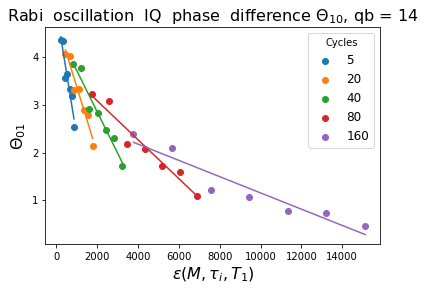

In [251]:
p_s = []
y_fits = []

def lin_func(x, m, b):
    return m * x + b

for i in range(5):
    indices = np.where(np.array(cycles) == cycles[i])[0]
    e = [errors[x] for x in indices]
    a = [amps[x] for x in indices]
    plt.scatter(e, a, label = str(cycles[i]))
    lin_p, _ = curve_fit(lin_func, e, a)
    p_s.append(lin_p)
    y_fits.append([lin_func(x, lin_p[0], lin_p[1]) for x in e])
    plt.plot(e, y_fits[i])
plt.legend(loc='upper right', title="Cycles", fontsize=12)
plt.ylabel('$\Theta_{01}$', fontsize=16)
plt.xlabel('$\epsilon(M, \\tau_i, T_1)$', fontsize=16)
plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$, qb = " + str(qb), fontsize=16)
# plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$", fontsize=16)

plt.show()

In [252]:
p_s

[array([-2.65195452e-03,  4.99943763e+00]),
 array([-1.39018655e-03,  4.76962772e+00]),
 array([-8.65650191e-04,  4.58647529e+00]),
 array([-4.08138700e-04,  3.90160145e+00]),
 array([-1.70477539e-04,  2.85789418e+00])]